In [48]:
import torch
from torch import nn
import torchvision
import torchvision.transforms as transforms
from  torch.utils.data import DataLoader
import copy
import pandas as pd
import numpy as np
import time

In [28]:
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    device = torch.device("cuda")
    torch.backends.cudnn.determinstic = True
    torch.backends.cudnn.benchmark = False
else:
    device = torch.device("cpu")

In [29]:
train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 32

data_set = torchvision.datasets.ImageFolder("data/train/", transform=train_transform)

train_set, test_set = torch.utils.data.random_split(data_set, [0.8, 0.2], generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle = True, num_workers=2 )

test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)


eval_set = torchvision.datasets.ImageFolder("data/test_all/", transform=test_transform)

eval_loader = DataLoader(test_set, batch_size=len(eval_set), shuffle=False, num_workers=2)


In [30]:
data_set.classes

['acoustic',
 'antenna',
 'bacteria',
 'battery',
 'bean',
 'beetle',
 'bicycle',
 'birch',
 'bird',
 'bomb',
 'bread',
 'bridge',
 'camera',
 'carbon',
 'cat',
 'corn',
 'crab',
 'crocodilian',
 'echinoderm',
 'egg',
 'elephant',
 'fish',
 'flower',
 'frog',
 'fungus',
 'gauge',
 'hammer',
 'icecream',
 'kangaroo',
 'memorial',
 'monkey',
 'motor',
 'nest',
 'palm',
 'pizza',
 'pot',
 'printer',
 'saw',
 'snake',
 'spice',
 'spider',
 'spoon',
 'squash',
 'swine',
 'tea',
 'tomato',
 'towel',
 'truck',
 'turtle',
 'worm']

In [31]:
eval_set.samples

[('data/test_all/no_label/00013066837824360356.JPEG', 0),
 ('data/test_all/no_label/00022240850406751722.JPEG', 0),
 ('data/test_all/no_label/0004927347689911432.JPEG', 0),
 ('data/test_all/no_label/000563265767796084.JPEG', 0),
 ('data/test_all/no_label/0006013938786831874.JPEG', 0),
 ('data/test_all/no_label/0006399600638603564.JPEG', 0),
 ('data/test_all/no_label/0006465730485515353.JPEG', 0),
 ('data/test_all/no_label/0007310156969084769.JPEG', 0),
 ('data/test_all/no_label/000912032407904162.JPEG', 0),
 ('data/test_all/no_label/0009124332639172117.JPEG', 0),
 ('data/test_all/no_label/0011255137743835242.JPEG', 0),
 ('data/test_all/no_label/0015368674426765594.JPEG', 0),
 ('data/test_all/no_label/0015522510526426725.JPEG', 0),
 ('data/test_all/no_label/0016476588773381984.JPEG', 0),
 ('data/test_all/no_label/0017273893401673623.JPEG', 0),
 ('data/test_all/no_label/0017919060529562048.JPEG', 0),
 ('data/test_all/no_label/0019043308335561226.JPEG', 0),
 ('data/test_all/no_label/00190

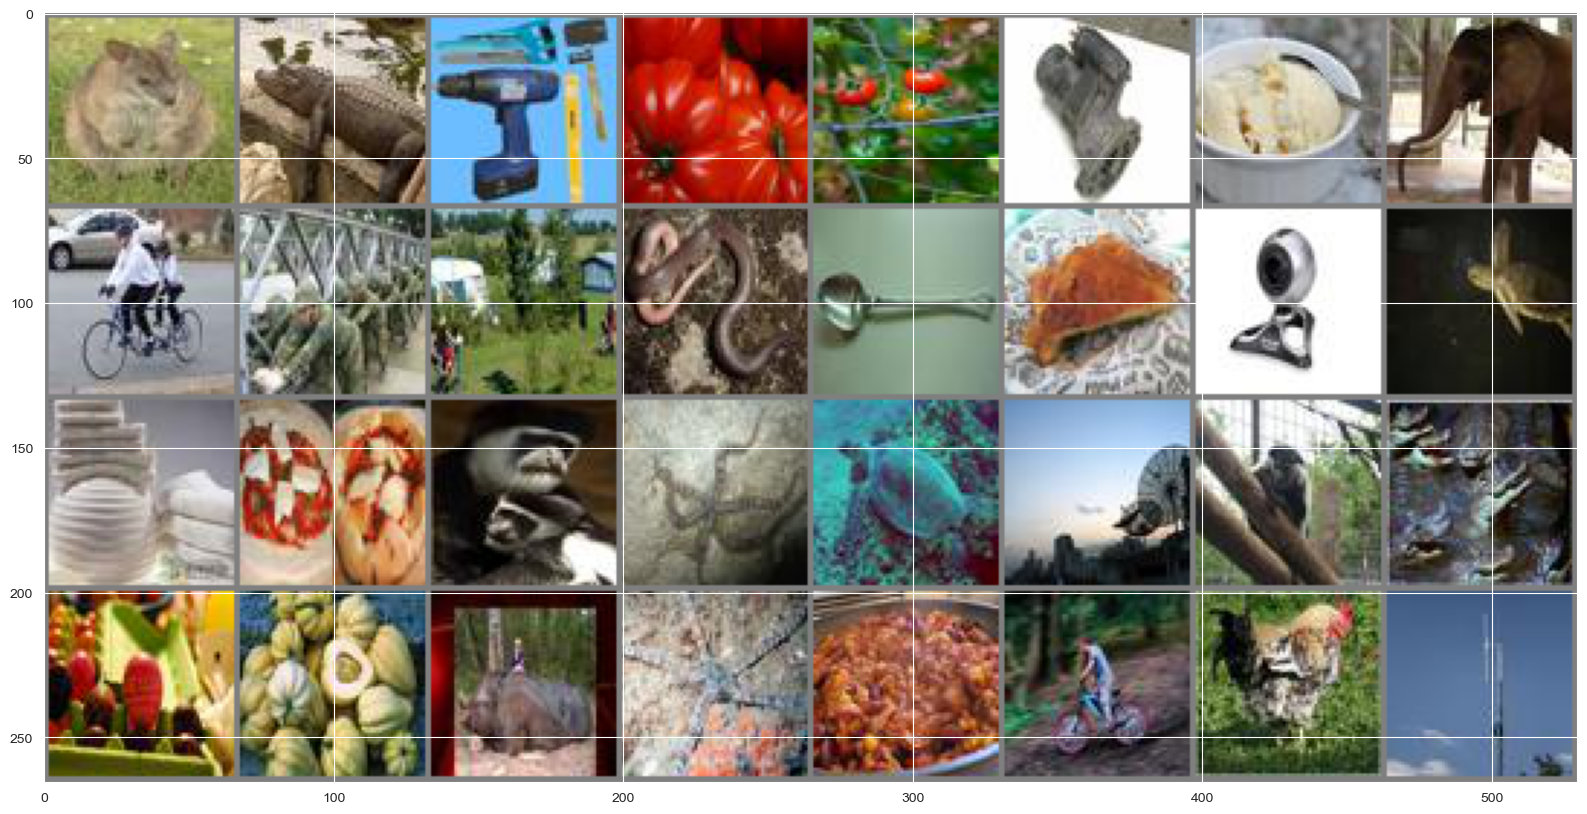

kangaroo crocodilian hammer tomato tomato motor icecream elephant bicycle bridge bicycle snake spoon bread camera turtle towel pizza monkey echinoderm turtle antenna monkey crocodilian   egg squash swine echinoderm  bean bicycle  bird antenna


In [36]:
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize = (20,10))

# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
classes = data_set.classes
print(' '.join('%5s' % classes[labels[j]] for j in range(batch_size)))

In [37]:
images[0].size()

torch.Size([3, 64, 64])

In [75]:
import torch.nn as nn


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        n_channels = 64
        n_conv = 20
        self.conv_net = nn.Sequential(
            #conv1
            nn.Conv2d(in_channels=3, out_channels=n_channels, kernel_size=7),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #conv2
            nn.Conv2d(in_channels=n_channels, out_channels= 2 * n_channels , kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            #conv3
            nn.Conv2d(in_channels= 2 * n_channels, out_channels= 2 * n_channels, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(in_channels= 2 * n_channels, out_channels=n_channels, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(2),

        )
        self.dense_net = nn.Sequential(
            nn.Linear(64, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 50)
        )

    def forward(self, x):
        x = self.conv_net(x)
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = self.dense_net(x)
        return x



In [76]:
model = Net()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Net(
  (conv_net): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dense_net): Sequential(
    (0): Linear(in_features=64, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=50, bias=True)
  )
)

In [82]:
def get_correct(outputs, labels):
    correct = 0
    _, predicted = torch.max(outputs.data, 1)
    correct += (predicted == labels).sum().item()

    return correct

In [83]:
def train(model, train_loader, criterion, optimizer):
    running_loss, running_corrects = 0, 0
    for inputs, labels in train_loader:
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # statistics
        running_loss += loss.item() * inputs.size(0)
        running_corrects += get_correct(outputs, labels)

    return running_loss, running_corrects

In [84]:
def test(model, test_loader, criterion, ):
    running_loss, running_corrects = 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = inputs.to(device), labels.to(device)

            # forward
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # statistics
            running_loss += loss.item() * inputs.size(0)
            running_corrects += get_correct(outputs, labels)
    return running_loss, running_corrects


In [85]:
def fit(model, train_loader, test_loader, criterion, optimizer, num_epochs=100):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = {}
    training_loss, training_acc, test_loss, test_acc = [], [], [], []

    for epoch in range(num_epochs):
        running_loss, running_corrects = 0, 0

        # train part
        running_loss, running_corrects = train(model, train_loader, criterion, optimizer)
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)
        training_loss.append(epoch_loss)
        training_acc.append(epoch_acc)
        if epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        # test part
        running_loss, running_corrects = test(model, test_loader, criterion)
        epoch_loss = running_loss / len(test_loader.dataset)
        epoch_acc = running_corrects / len(test_loader.dataset)
        test_loss.append(epoch_loss)
        test_acc.append(epoch_acc)

        print(f"[{epoch}/{num_epochs}]\n", f'train_loss: {training_loss[-1]:.4f} train_acc: {training_acc[-1]:.4f}\n', f'test_loss: {test_loss[-1]:.4f} test_acc: {test_acc[-1]:.4f}')

    time_elapsed = time.time() - since

    print(f'\nTraining complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc*100:2f} %')

    history.update({'training_loss' : training_loss, 'training_acc': training_acc, 'test_loss' : test_loss, 'test_acc' : test_acc})
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, history

In [86]:
_, history = fit(model, train_loader, test_loader, criterion, optimizer)

KeyboardInterrupt: 

In [ ]:
def acc_per_class():
        # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in test_loader:
            images, labels = data
            images = images.to(device)
            outputs = model(images).cpu()
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1


    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                       accuracy))

acc_per_class()

In [ ]:
def my_plot(history):
    plt.figure(figsize=(20, 10))
    # plt.style.use("seaborn-paper")
    # summarize history for loss
    plt.plot(np.arange(len(history['training_loss'])),history['training_loss'])
    plt.plot(np.arange(len(history['training_loss'])),history['test_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()
     # summarize history for accuracy
    plt.figure(figsize=(20, 10))
    plt.plot(np.arange(len(history['training_loss'])),history['training_acc'])
    plt.plot(np.arange(len(history['training_loss'])),history['test_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

my_plot(history)

In [ ]:
def run_eval():
    with torch.no_grad():
        images, _ = next(iter(eval_loader))
        images = images.to(device)
        outputs = net(images).cpu()
        _, predicted = torch.max(outputs.data, 1)

        file_names = [name[23:] for name, _ in eval_set.samples]
        new_df = pd.DataFrame(file_names, predicted)
        new_df.to_csv("brus_maj.csv", index=False)
run_eval()

AttributeError: 'ImageFolder' object has no attribute 'img_infos'

In [26]:
file_names = [name[23:] for name, _ in eval_set.samples]
file_names

['00013066837824360356.JPEG',
 '00022240850406751722.JPEG',
 '0004927347689911432.JPEG',
 '000563265767796084.JPEG',
 '0006013938786831874.JPEG',
 '0006399600638603564.JPEG',
 '0006465730485515353.JPEG',
 '0007310156969084769.JPEG',
 '000912032407904162.JPEG',
 '0009124332639172117.JPEG',
 '0011255137743835242.JPEG',
 '0015368674426765594.JPEG',
 '0015522510526426725.JPEG',
 '0016476588773381984.JPEG',
 '0017273893401673623.JPEG',
 '0017919060529562048.JPEG',
 '0019043308335561226.JPEG',
 '0019061561630828727.JPEG',
 '0019565696841159497.JPEG',
 '0021928123381425024.JPEG',
 '002223214863066203.JPEG',
 '002381433033175284.JPEG',
 '0024564313592826403.JPEG',
 '00252503764726697.JPEG',
 '0026931047075869907.JPEG',
 '0029134638002292768.JPEG',
 '0029929765775938977.JPEG',
 '003039764483954377.JPEG',
 '0030516179846837854.JPEG',
 '0031080759870124597.JPEG',
 '0031311665918588583.JPEG',
 '0033250594834229874.JPEG',
 '0034299586028888607.JPEG',
 '0036158547876422586.JPEG',
 '00367530227858614